# A basic history matching example using a deterministic function

In [1]:
import math
import matplotlib.pyplot as plt
import numpy as np
import random

In this basic example, the observation measurement has no error.

We want to find the range of values in X that, given to the simulator, may produce the result y = -0.7

In [2]:
y = -0.7  # observation we want to find with the model

The simulator uses a sin function with added noise.

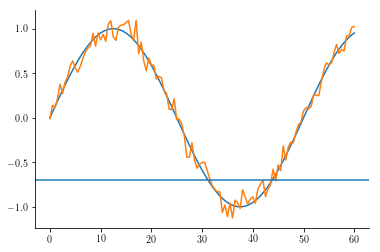

In [3]:
def f(x):
    """ the simulator """
    return math.sin(0.04 * math.pi * x)  + random.gauss(0, 0.1)

# example plot of simulator output
X = np.linspace(0, 60, 121)
plt.plot(X, [math.sin(0.04 * math.pi * x) for x in X])  # without noise
plt.plot(X, [f(x) for x in X])  # with simulator results
plt.axhline(y=y, xmin=0, xmax=1)  # observation

Get the variance of the ensembles.
This is something that's a bit unclear in the papers I've read. This is my interpretation - it could be wrong:
Test different inputs for multiple (k) ensembles and calculate the variance of those ensembles (for each input). Then calculate the mean across those variances.

In [4]:
k = 5  # total ensembles run for each input (keeping it low as it's a simple model, should really be at least 25)
def get_v_ens(X):
    vars_range = []
    for x in X:
        vars_range.append(np.var([f(x) for _ in range(k)], ddof=1))
    return np.mean(vars_range)

In [5]:
v_ens = get_v_ens(range(0, 60, 6))

The implausibility score takes the difference between the simulator result and the observation, and divides this by all uncertainties in the model. At the moment, there is only variability in the ensemble results (v_ens).
It could also take into account uncertainty in the observation and model discrepency.

In [6]:
def implaus(x):
    """ Calculate the implausibility of the paramter value x"""
    num = abs(y - f(x))  # no emulator, only simulator
    denom = np.sqrt(v_ens)
    return num / denom

Run the first wave of history matching and plot the implausibility of each sample in the sample space (X).
The plot shows orange for implausible values (where implausibility is above 3) and blue for plausible values.

In [7]:
def wave(implaus_space):
    plaus_space = []
    # plot the results
    for x in implaus_space:
        score = implaus(x)
        if score < 3:
            plt.scatter(x, score, color=u'#1f77b4')
            plaus_space.append(x)
        else:
            plt.scatter(x, score, color=u'#ff7f0e')
    plt.axhline(y=3, xmin=0, xmax=1)
    return np.array(plaus_space)

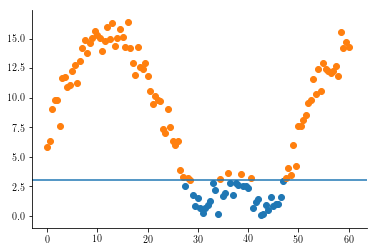

In [8]:
# The sampling space would normally be chosen using an LHS-design,
# but this is a basic deterministic example so linspace will suffice.
X = np.linspace(0, 60, 121)
plaus_X = wave(X)

These results show that values in the range [28, 45.5] are considered plausible.
These ranges will differ each time the wave is run due to the Gaussian noise added to the simulator.

# An example using stationsim

In this case, I'm using an "identical twin", in which one run of a simulation is used as the real world observation. This was run with default settings, with a population of 75 and random seed 1376479047.

The goal is to explore the parameter space of speed_mean to find a range of values with which the simulation takes the expected amount of time (i.e. all people have left the station area in the measured time).

The identical twin used the default speed_mean:1.

In [9]:
from sys import path
path.append('..')  # change as required
from stationsim.stationsim_model import Model

# "real world" observation
y = 1802
y_pop_total = 75
y_seed = 1376479047

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [10]:
def f(x):
    model = Model(pop_total=y_pop_total, speed_mean=x, do_print=False)
    for _ in range(model.step_limit):
        model.step()
    return model.step_id  # finish time

In [11]:
# test five different inputs
v_ens = get_v_ens(linspace(0.4, 6, 5))

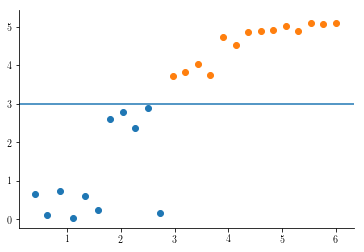

In [12]:
# Test speed_mean in the range [0.4, 6].
# Again, the sampling space would normally be chosen using an LHS-design.
# I'm keeping it very simple for now.
X = np.linspace(0.4, 6, 25)
plaus_X = wave(X)

Values around 0.4 to 2.7 are considered plausible. Higher values are implausible.
The results seem about right given the correct result should be 1.
As the simulator is stochastic, these ranges will be different each time

Now do the second wave, testing within the new plausible region.
The code I've done for this is overly simple because
1. it assumes the plausible region is convex
2. there is no clever sampling (I'm using linspace still)

First, get the variance in this region.

In [13]:
# get variance in new plausible region
v_ens = get_v_ens(np.linspace(min(plaus_X), max(plaus_X), 5))

Second, test the plausibility of this new region with the new ensemble variance.

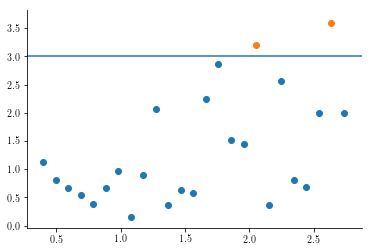

In [14]:
X = np.linspace(min(plaus_X), max(plaus_X), 25)
plaus_X = wave(X)

Nothing has really changed. Does this mean we're unable to narrow down the plausible space, or that I've misunderstood something?

# 